In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

In [246]:
natgas = pd.read_csv("Nat_Gas.csv")
natgas.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [247]:
natgas['Returns'] = natgas['Prices'].diff()
natgas['Dates'] = pd.to_datetime(natgas['Dates'])
natgas = natgas[1:]
natgas.head()

,Dates,Prices,Returns
1,2020-11-30,10.3,0.2
2,2020-12-31,11.0,0.7
3,2021-01-31,10.9,-0.1
4,2021-02-28,10.9,0.0
5,2021-03-31,10.9,0.0


In [248]:
curr_X = natgas['Dates']
curr_Y = natgas['Returns']

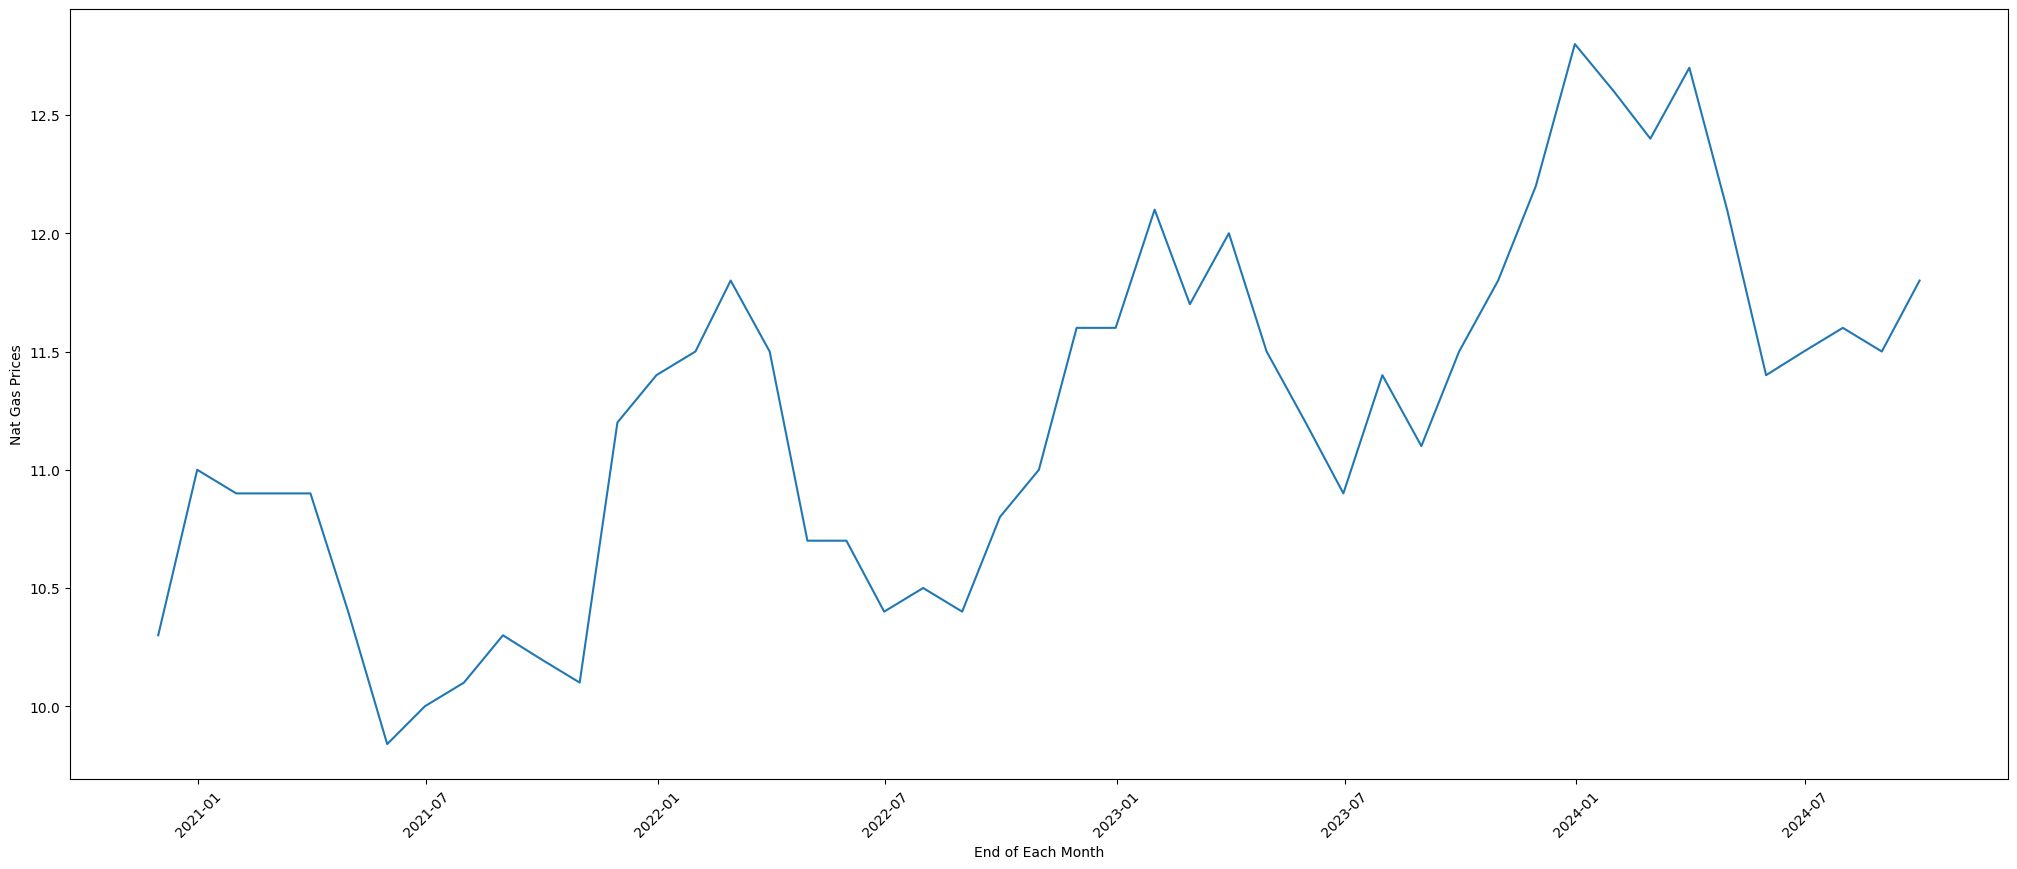

In [249]:
plt.figure(figsize=(25, 10))
plt.plot(natgas['Dates'], natgas['Prices'])
plt.xlabel("End of Each Month")
plt.ylabel("Nat Gas Prices")
plt.xticks(rotation=45)
plt.show()

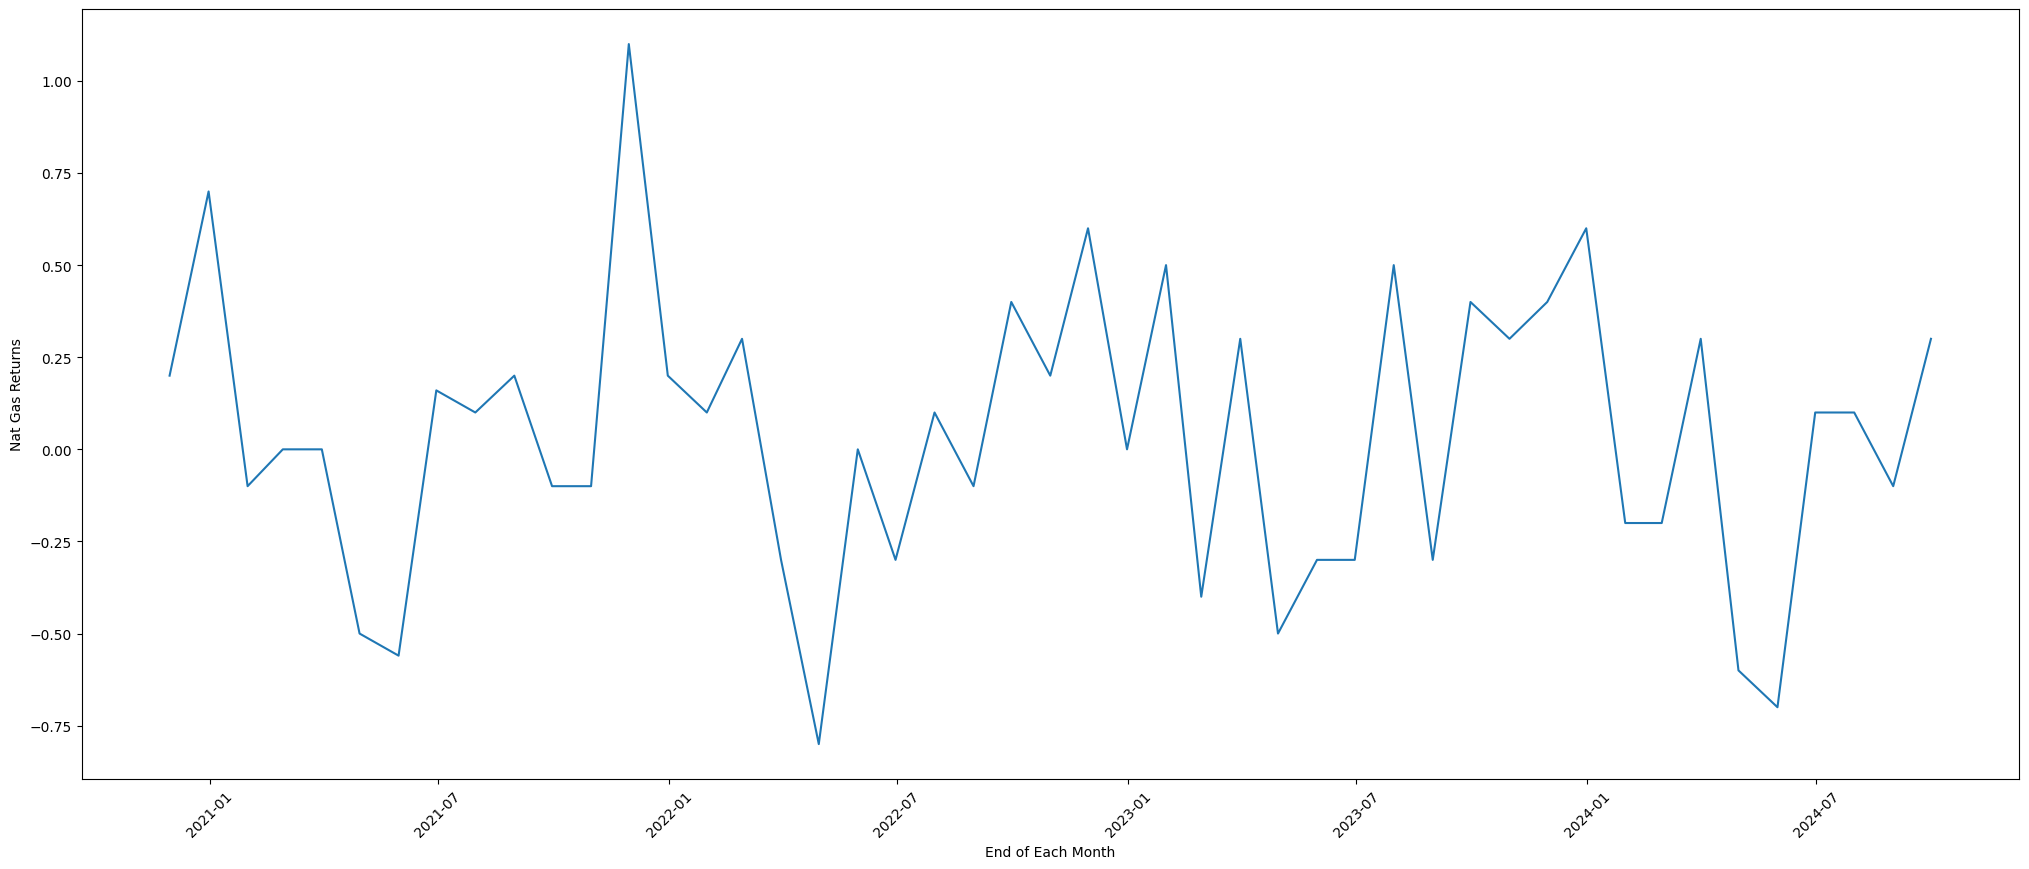

In [250]:
plt.figure(figsize=(25, 10))
plt.plot(natgas['Dates'], natgas['Returns'])
plt.xlabel("End of Each Month")
plt.ylabel("Nat Gas Returns")
plt.xticks(rotation=45)
plt.show()

In [251]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
perform_adf_test(natgas['Returns'])

ADF Statistic: -6.844774
p-value: 0.000000


In [252]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import aic, bic
from sklearn.metrics import mean_squared_error

In [253]:
def fit_and_predict(train, test_len, order):
    predictions = []
    residuals = []
    history = list(train)
    for t in range(test_len):
        # Predict the next step using the previous values in history (which contains actual values)
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        if t == 0:
            residuals = model_fit.resid

        # One-step forecast
        pred = model_fit.forecast()[0]

        # Save prediction
        history.append(pred)
        predictions.append(pred)

    return predictions

In [254]:
def find_para(lgret):
    p_range = range(0, 6)
    q_range = range(0, 6)

    # Store results
    results = []

    # Iterate through combinations of p and q
    for p, q in itertools.product(p_range, q_range):
        try:
            model = ARIMA(lgret, order=(p, 0, q))
            model_fit = model.fit()

            # Extract AIC and BIC
            aic_value = model_fit.aic
            # bic_value = model_fit.bic

            # Store results
            results.append((p, q, aic_value))
        except Exception as e:
            print(f"Error with ARIMA({p}, 0, {q}): {e}")

    # Convert results to a DataFrame for easy sorting
    results_df = pd.DataFrame(results, columns=['p', 'q', 'AIC'])

    # Find the best parameters based on AIC and BIC
    best_aic = results_df.loc[results_df['AIC'].idxmin()]
    # best_bic = results_df.loc[results_df['BIC'].idxmin()]

    print("Best parameters based on AIC:")
    print(best_aic['p'], best_aic['q'])

    if not ((best_aic['p'] == 0) & (best_aic['q'] == 0)):
        return int(best_aic['p']), 0, int(best_aic['q'])
    else:
        return 0, 0, 2

In [255]:
order = find_para(natgas['Returns'])

Best parameters based on AIC:
5.0 5.0


In [256]:
def generate_month_end_dates(start, end):
    dates = pd.date_range(start=start, end=end, freq='M')
    return [date.strftime('%Y-%m-%d') for date in dates]

start_date = '2024-10-31'
end_date = '2025-10-31'
pred_X = pd.Series(generate_month_end_dates(start_date, end_date))
pred_len = len(generate_month_end_dates(start_date, end_date))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2024-10-31'),
  Text(1, 0, '2024-11-30'),
  Text(2, 0, '2024-12-31'),
  Text(3, 0, '2025-01-31'),
  Text(4, 0, '2025-02-28'),
  Text(5, 0, '2025-03-31'),
  Text(6, 0, '2025-04-30'),
  Text(7, 0, '2025-05-31'),
  Text(8, 0, '2025-06-30'),
  Text(9, 0, '2025-07-31'),
  Text(10, 0, '2025-08-31'),
  Text(11, 0, '2025-09-30'),
  Text(12, 0, '2025-10-31')])

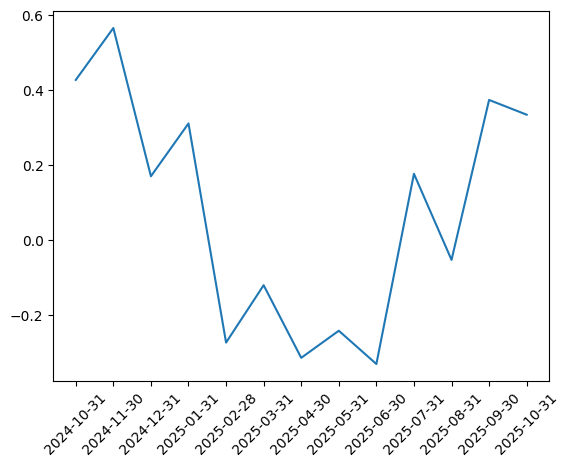

In [288]:
pred_Y = pd.Series(fit_and_predict(natgas['Returns'], pred_len, order))

plt.plot(pred_X, pred_Y)
plt.xticks(rotation=45)

In [258]:
X = pd.concat((curr_X, pred_X))
Y = pd.concat((curr_Y, pred_Y))

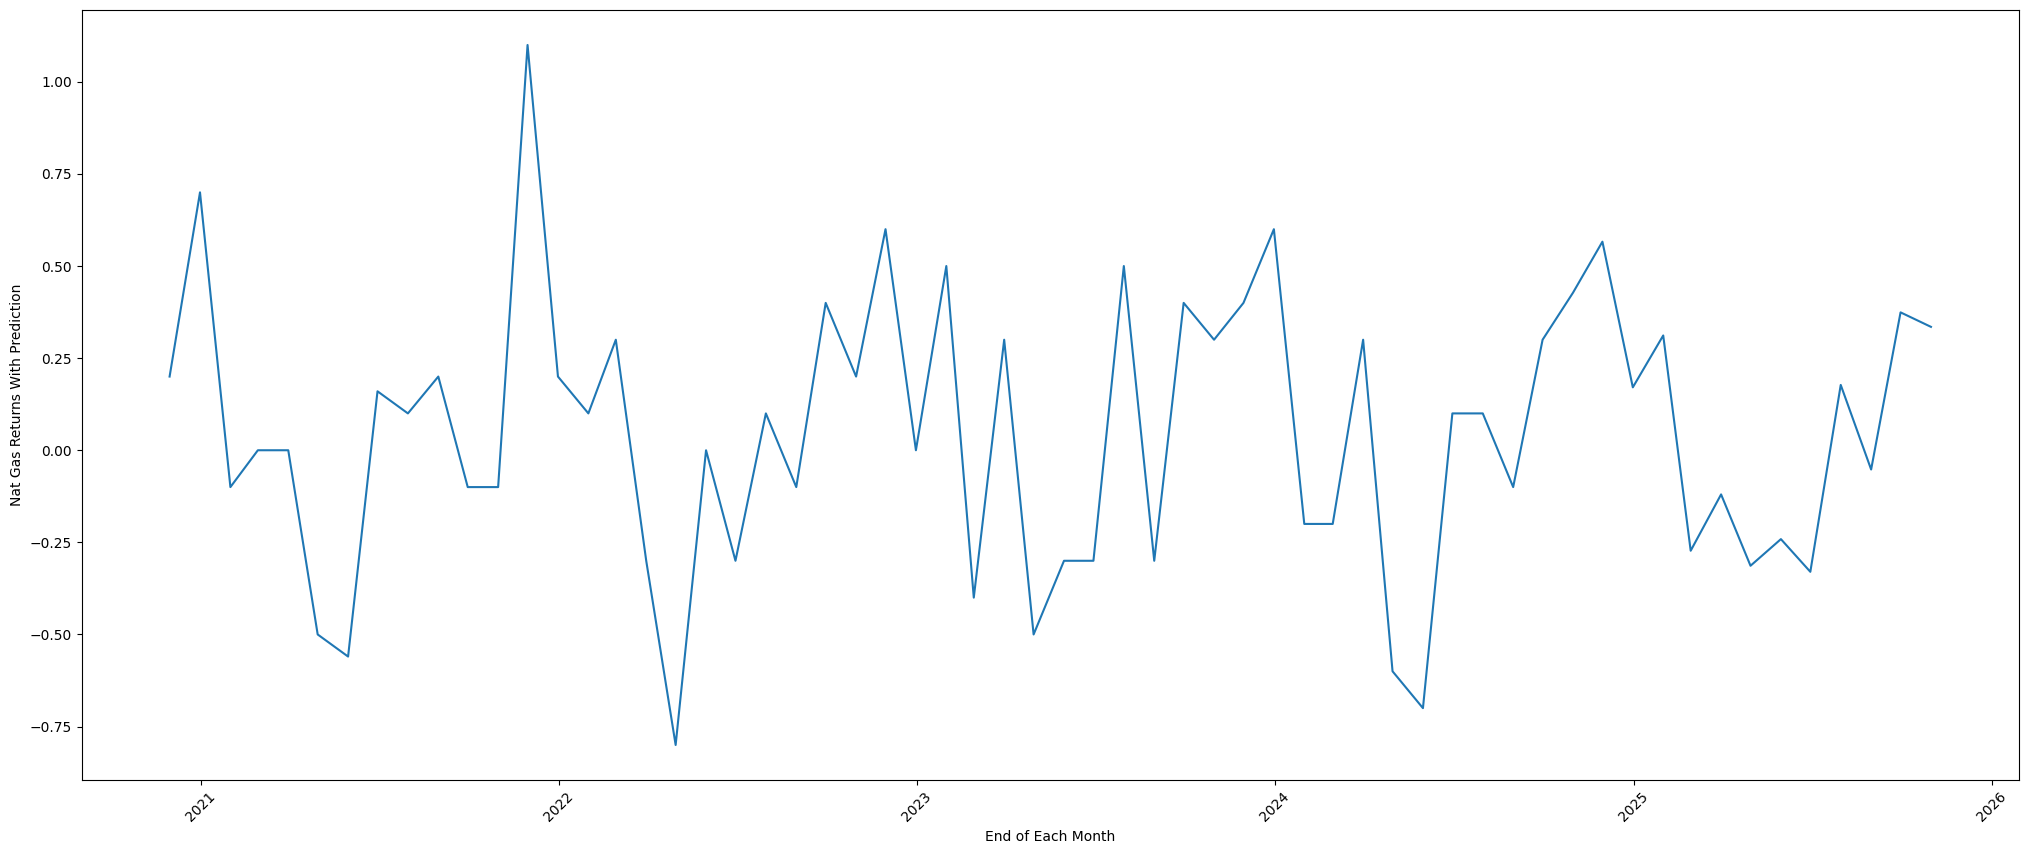

In [259]:
plt.figure(figsize=(25, 10))
plt.plot(X, Y)
plt.xlabel("End of Each Month")
plt.ylabel("Nat Gas Returns With Prediction")
plt.xticks(rotation=45)
plt.show()

In [260]:
res = pd.DataFrame()
res['Dates'] = X
res['Predicted_Returns'] = Y
res['Predicted_Prices'] = res['Predicted_Returns'].cumsum()
res['Dates'] = pd.to_datetime(res['Dates'])
res.head()

,Dates,Predicted_Returns,Predicted_Prices
1,2020-11-30,0.2,0.2
2,2020-12-31,0.7,0.9
3,2021-01-31,-0.1,0.8
4,2021-02-28,0.0,0.8
5,2021-03-31,0.0,0.8


In [261]:
from datetime import datetime

present = natgas.iloc[-1]['Dates']
history = res[res['Dates'] <= present]
predicted_future = res[res['Dates'] > present]

In [262]:
# ptA = [history.iloc[-1]['Dates'], history.iloc[-1]['Predicted_Prices']]
# ptB = [predicted_future.iloc[0]['Dates'], predicted_future.iloc[0]['Predicted_Prices']]
# ptA, ptB

In [263]:
history.tail()

,Dates,Predicted_Returns,Predicted_Prices
43,2024-05-31,-0.7,1.3
44,2024-06-30,0.1,1.4
45,2024-07-31,0.1,1.5
46,2024-08-31,-0.1,1.4
47,2024-09-30,0.3,1.7


In [264]:
predicted_future.head()

,Dates,Predicted_Returns,Predicted_Prices
0,2024-10-31,0.427630,2.127630
1,2024-11-30,0.566109,2.693739
2,2024-12-31,0.170742,2.864481
3,2025-01-31,0.311559,3.176041
4,2025-02-28,-0.272767,2.903274


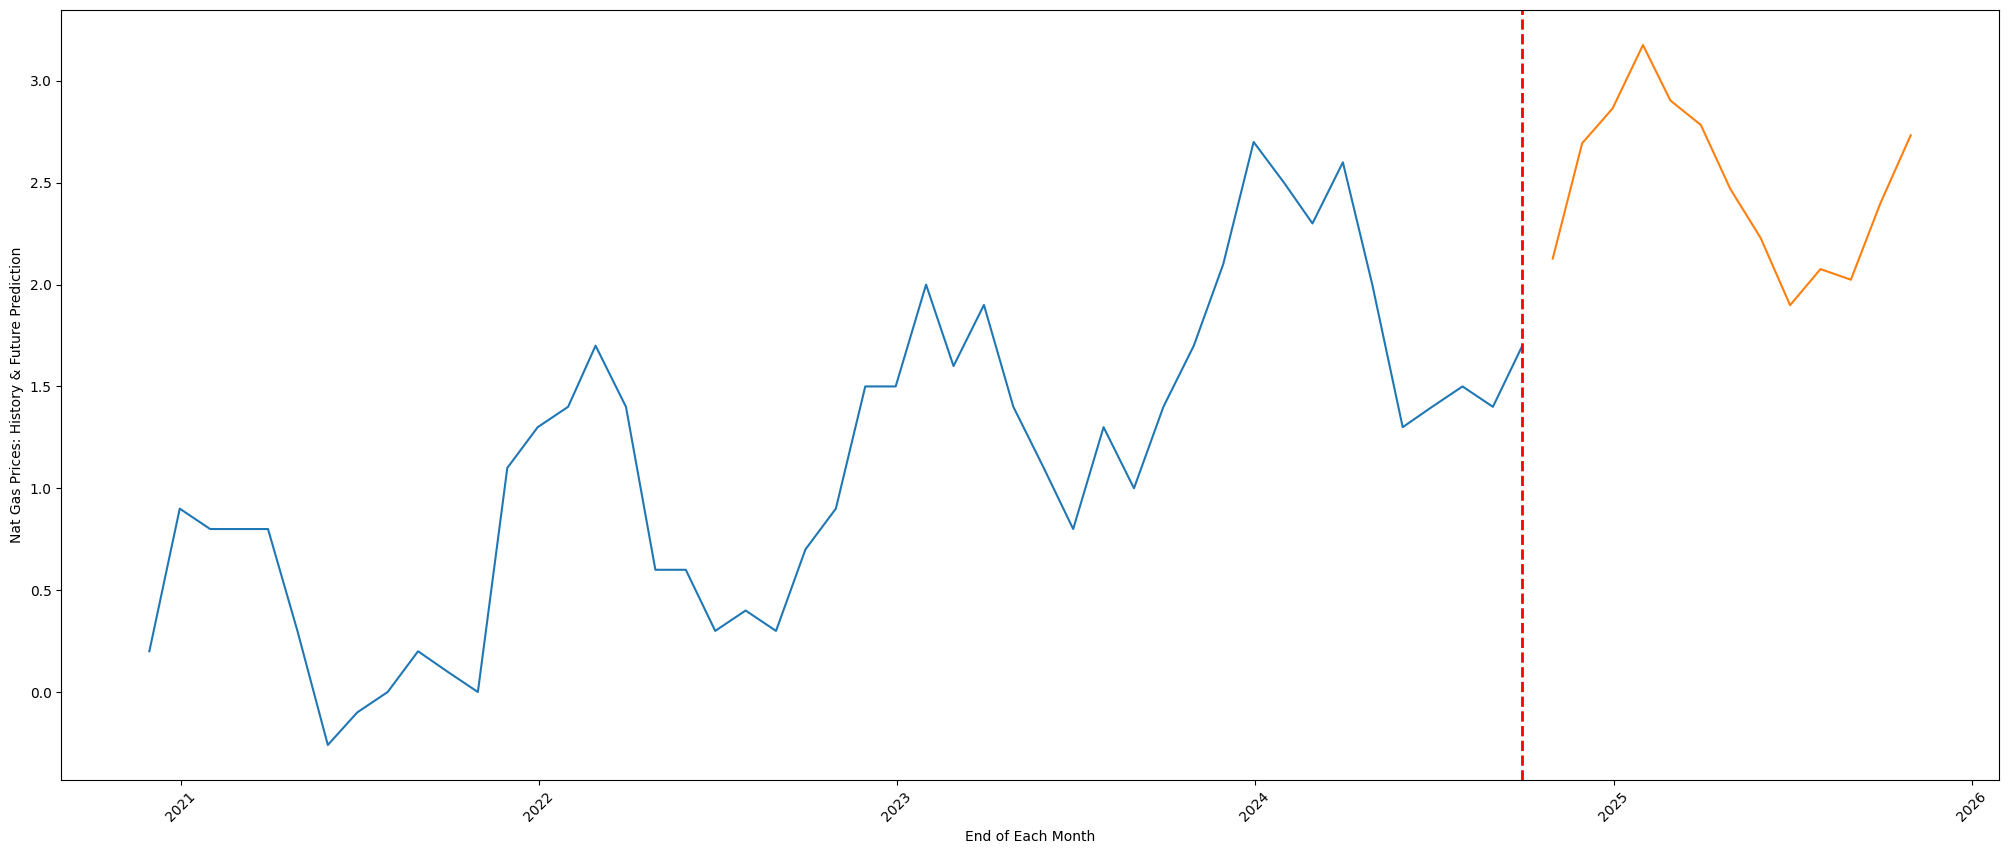

In [265]:
plt.figure(figsize=(25, 10))
plt.plot(history['Dates'], history['Predicted_Prices'])
plt.plot(predicted_future['Dates'], predicted_future['Predicted_Prices'])
# plt.plot(ptA, ptB)
plt.axvline(x=present, color='r', linestyle='--', linewidth=2)
plt.xlabel("End of Each Month")
plt.ylabel("Nat Gas Prices: History & Future Prediction")
plt.xticks(rotation=45)
plt.show()